In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [8]:
# make the plots bigger
plt.rcParams["figure.figsize"] = (10,10)

# Edges

Let's take a step back from directly looking at images and think about one of the most useful mathematical operations - the derivative.

Derivatives give us the rate of change of a function. So for example,  for the following function:

Text(0.5, 1.0, 'Plateau function')

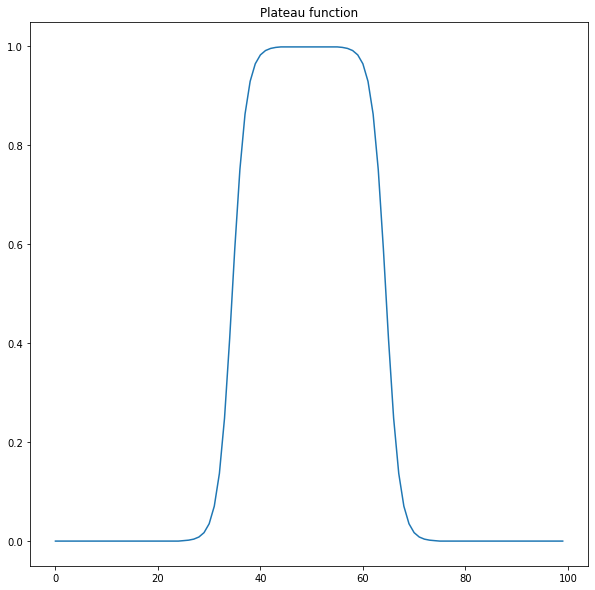

In [51]:
def generate_function_samples(width=20):
    a = np.zeros((100, ))
    b = np.linspace(-7, 7, width)
    b = 1/(1+np.exp(-b))
    a[25:45] = b
    a[45:55] = b[-1]
    a[55:75] = b[::-1]
    return a
    
f = generate_function_samples()
plt.plot(f)
plt.title("Plateau function")

It seems reasonable to assume the derivatives will peak when the function grows and falls, but that they would be near zero in the flat regions.

We can verify this by:

Text(0.5, 1.0, 'Derivative of the plateau function.')

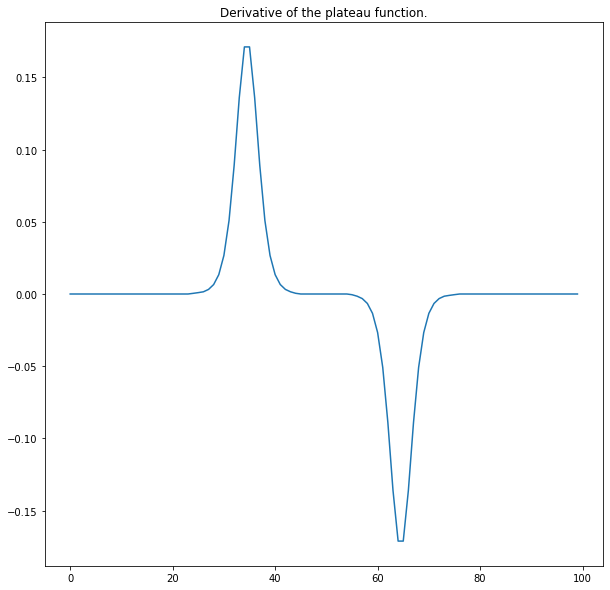

In [53]:
df = np.gradient(f)
plt.plot(df)
plt.title("Derivative of the plateau function.")

In mathematics you've seen plenty of times how to find extrema of a function, i.e. when the function "peaks", by equating the derivative with a zero and then solving for the variable(s). This is because in the "peak" of a function it will overturn from growing to falling and to do that the function derivative will have to pass through zero at some point. 

However, what we will be interested more in today, are the maxima and minima of the derivatives. Let's find the index in which they occur.           
Can you already guess why?

In [59]:
max_val, min_val = df.max(), df.min()
max_idx = np.where(df == max_val)[0][0]
min_idx = np.where(df == min_val)[0][0]
print(f"Idx max: {max_idx}")
print(f"Idx min: {min_idx}")

Idx max: 35
Idx min: 64


Text(0.5, 1.0, 'Plateau function')

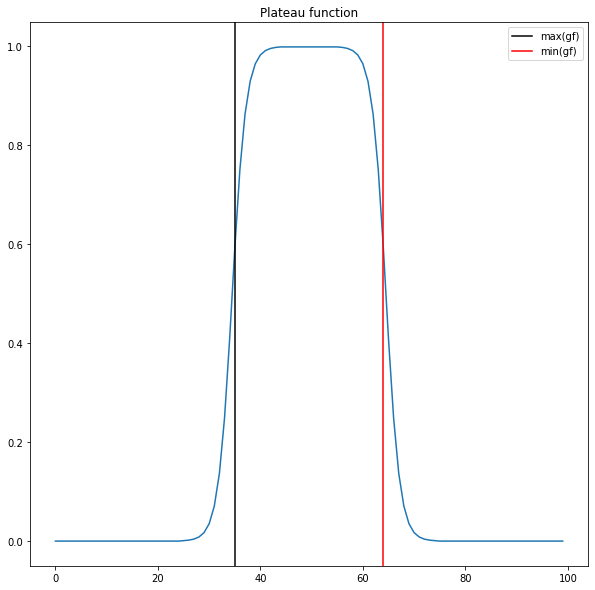

In [63]:
plt.plot(f)
plt.axvline(max_idx, color="black", label="max(gf)")
plt.axvline(min_idx, color="red", label="min(gf)")
plt.legend()
plt.title("Plateau function")

Ok, cool. So in some ways the derivatives can find "edges" of functions, defined as the width between the maxima and minima of convex or concave functions.         
It seems defining an "edge" of a function is more tricky than one would want. Namely, it is obvious that we have in general managed to locate where our function is, but we are missing some of the "signal" on the edges of that function. This, for example, would be a problem if that signal was representing the brightness of an object, since then we would be constantly underestimating how bright our objects really are. 

It is worth-while to mention at this point, even though measurements of widht are not where we are going here, that the measure of width most often used in astronomy is that of **F**ull **W**idth at **H**alf **M**aximum (FWHM). Given that we are dealing with a plateau function picking a "peak" of our fnction is not obvious but let's aim to hit about the mid-point of the plateau.

Idx left: 35
Idx right: 64


Text(0.5, 1.0, 'Plateau function FWHM')

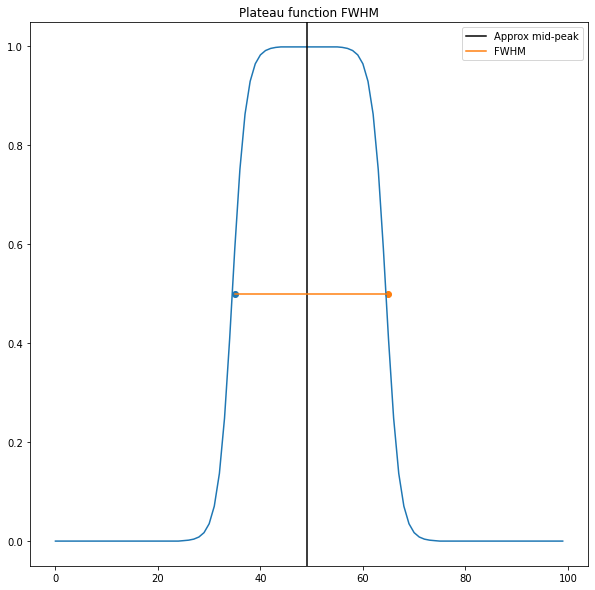

In [94]:
mid_point_idx = 49

plt.plot(f)
plt.axvline(mid_point_idx, color="black", label="Approx mid-peak")

max_val = f.max()
half_max = max_val/2
left = np.where(f[:mid_point_idx] > half_max)[0][0]
right = np.where(f[mid_point_idx:] < half_max)[0][0] + mid_point_idx

print(f"Idx left: {max_idx}")
print(f"Idx right: {min_idx}")

plt.scatter(left, half_max)
plt.scatter(right, half_max)
plt.plot([left, right], [half_max, half_max], label="FWHM")
plt.legend()
plt.title("Plateau function FWHM")

Notice that the retrieved indices for our left and right points are exactly the same as those for derivatives. This is not always the case, but it is not a coincidence in this case either. 

FWHM has a long statistical backing in the area of signal processing and can usually be related to other properties of distributions. Most famously, for a Gaussian $f(x, x_0, \sigma)$ the $FWHM=2\sqrt{2\ln2}\sigma \approx 2.355\sigma$    

Ok, so this was a bit of a sidequest, how does this help us and how is this useful for us in terms of computer vision problems?        
To see that all we have to do is generalize this issue to the 2D dimensions.

## Generalizing to images

While we are already here - I think it's also worthy to mention that OpenCV is **NOT** the only computer vision library out there (shocking I know). They all pretty much follow the same conventions and the main differences are usually performance and feature completness, with different libraries usually competing for different niches. Apart from OpenCV, you also have availible the `scikit-image` and `scipy-ndimage` libraries, which are more Python oriented and thus tend to perform slower, but are more natural to use. For example:

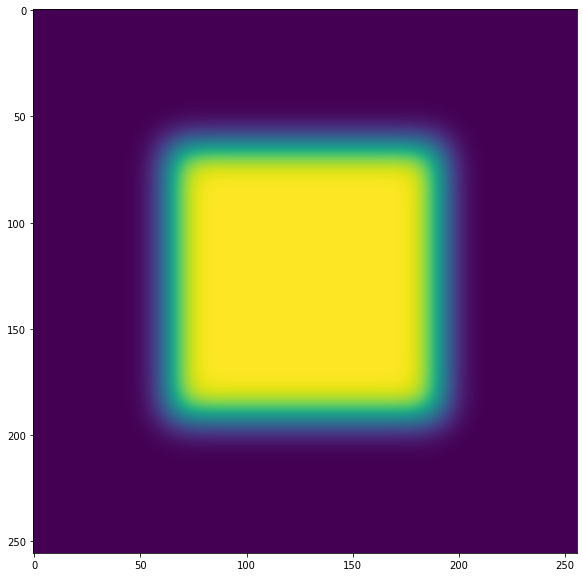

In [23]:
from scipy import ndimage

img = np.zeros((256, 256))
img[64:-64, 64:-64] = 1
img = ndimage.gaussian_filter(img, 8)
plt.imshow(img)

So let's see what the derivative of this image gives us?

In [24]:
grad_img = np.gradient(img)
print("N elements: len(grad_img)")
grad_img

N elements: len(grad_img)


[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

Hmm, so we have a list of 2 arrays?!?       
Would be confusing if we didn't know what numerical gradients really are. To calculate numerical gradients, formally, we expand a function into a Taylor series and keep couple of the first elements, we then re-arange these elements to express the first (or whichever) derivative over the known function values. To keep it short, what we basically end up with is the difference of the neighbouring points divided by the distance between them! On the example of our function $f$ above this means:
```
         (f[2] - f[0])
df[1] = ---------------
              2
```
(note that this works out like this here because all our steps are exactly 1 etc.. but the point stands).

So in images, this means we have multiple neighbours to look at, and therefore multiple options to pick from. In an example image cutout:
```
1 2 3 
4 5 6
7 8 9
```
do we look for gradient in point `5` by using elements `4` and `6`, or `2` and `8`, or perhaps even `1` and `9`?

Because `np.gradient` doesn't know which one we want it returns 2 arrays. One for left-to-right gradients and one for up-down gradients. OpenCV, Scipy and others of course, have much more powerful gradient operators that let us pick which one we want. We will see some of them in a second, but firs let's visualize our gradients.

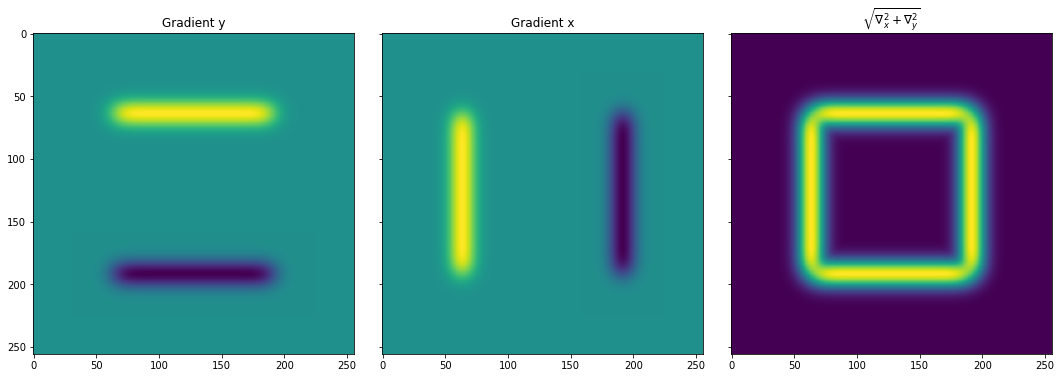

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

absgrad = np.sqrt(grad_img[0]**2 + grad_img[1]**2)
axes[0].imshow(grad_img[0])
axes[1].imshow(grad_img[1])
axes[2].imshow(absgrad)

axes[0].set_title("Gradient y")
axes[1].set_title("Gradient x")
axes[2].set_title(r"$\sqrt{ \nabla_x^2 + \nabla_y^2 }$")

plt.tight_layout()

This is basically the basis of **all** edge detectors out there. They are of course smarter than the basic approach demonstrated here, because not only do they include more neighbouring pixels in their calculations, but also because they work in cases where there is also noise in the image. Most edge detectors are really noise-prone and struggle to perform well in those circumstances. They also perform some form of edge thinning, because the edge can only be a border 1px wide etc.

If you are still struggling to see why this worked, try plotting a row or a column of the image of a square as a function and compare what you get with the plateau function from the start of the document.

In [ ]:
# you can do that here

# Edge detectors

If you're really into it you can read all about the additional steps and different derivation operators on any of the following links:     
https://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html          
https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html        
https://docs.opencv.org/4.x/d5/d0f/tutorial_py_gradients.html    

but in my experience they all kind of work similarly enough to work in our case - because the data we are after lives significantly far above the noise that they do not present a large challenge to any of these algorithms. Therefore we won't do too much comparison testing. 

What is nice to notice is that it performs two-fold work for us. Firstly, it ensures that the edges follow pixels of the same intensities along the edge. Secondly, it ensures that it thins the edges to 1px width, in such a way that only the, locally, strongest edges remain. Meaning that it doesn't return multiple results for the same edge. 

Effectively, it provides us with a bitmap that we can use to segment objects in our image

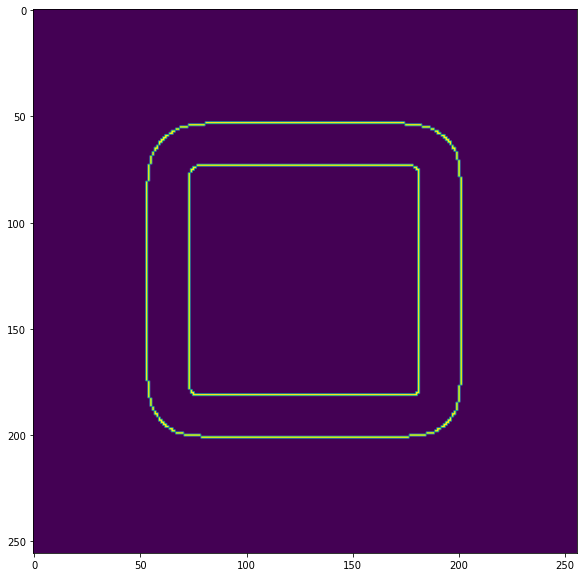

In [30]:
absgrad = cv2.normalize(absgrad, 0, 255)
absgrad = cv2.convertScaleAbs(absgrad)
threshold, thresholded_image = cv2.threshold(absgrad, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
edges = cv2.Canny(thresholded_image, 100, 200)
plt.imshow(edges)

# Summary

* Derivatives can be used to detect peaks of functions
  * but they can also be re-purposed to find the "widths" of concave and convex functions
* FWHM is the most often used definition of signal "width" in signal processing
  * and of object sizes on the image in Astronomy
* All edge detectors are based on detecting changes in pixel brightness values 
  * they do that by considering pixel brightness values as a function and then they 
    use the derivatives of that function to find the edges
  * there are different ways to define these derivatives, depending on what types of edges you want to look for.
  * the job of an edge detector, however, is to find 1 edge for our object, and to find the same edge consistently,
    even if that object is very thick. 


# Extra Section

This section can be quite demanding on the memory of your laptop/PC. It isn't crucial to complete as it mostly repeats similar processing as above as it applies to an image of the sky.

Let's start with the same copy-paste code we saw in every notebook so far:

In [3]:
import astropy.visualization as aviz
import astropy.io.fits as fitsio

def open_image(imgpath, mode=cv2.IMREAD_GRAYSCALE):
    """
    Open an image as an numpy array.
    
    Parameters
    ----------
    imgpath : `str`
        Path to the image.
    mode : `int`, optional
        Mode with which to open the image, i.e. color vs black and white.
        Must be one of the OpenCV recognized constants such as 
        `cv2.IMREAD_GRAYSCALE` or `cv2.IMREAD_COLOR`
        
    Returns
    --------
    img : `np.array`
        Image.
        
    Raises
    ------
    OSError - when the file could not be opened.
    """
    img = cv2.imread(imgpath, mode)
    if img is None:
        raise OSError("Can't open file:", imgpath)
    else:
        return img

def show(img, ax=None, show=True, title=None, **kwargs):
    """
    Show image using matplotlib.
    
    Parameters
    ----------
    img : `np.array`
        Image to display.
    ax : `matplotlib.pyplot.Axes` or `None`, optional
        Ax on which to plot the image. If  no axis is given
        a new figure is created.
    kwargs : `dict`, optional
        Keyword arguments that are passed to `imshow`.
    """
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.imshow(img, **kwargs)
    ax.set_title(title, fontsize=22)
    return ax

Then the same magical AstroPy incatation for which I need you to push the "I believe" button once again:

<AxesSubplot:>

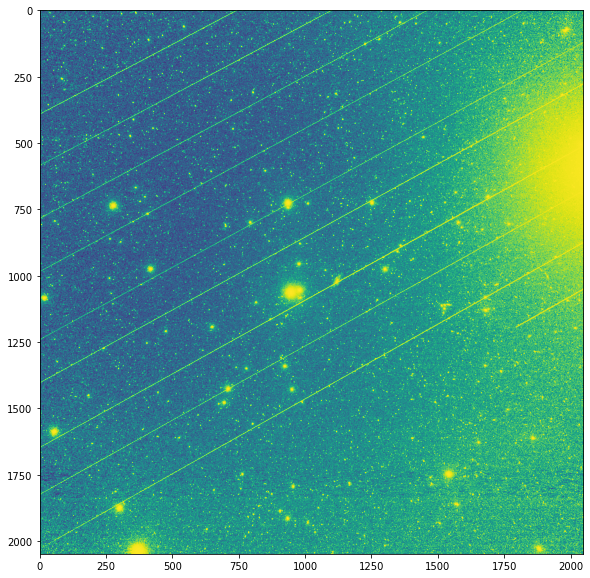

In [11]:
hdulist = fitsio.open("images/bi327715.fits")
img = hdulist[0].data

# let's use the pretty AstoPy stretch to visualize our data.
# Naturally we want to avoid doing this and then analyzing this data,
# because all of the brightness difference between our trails and background is lost
stretch = aviz.HistEqStretch(img)
norm = aviz.ImageNormalize(img, stretch=stretch, clip=True)
histeq = norm(img).data

show(histeq)

And then finally the "bulk" of the work. Can you figure out what I did here and, more importantly, why?

This one might be a bit harder than the previous questions.figure

<AxesSubplot:>

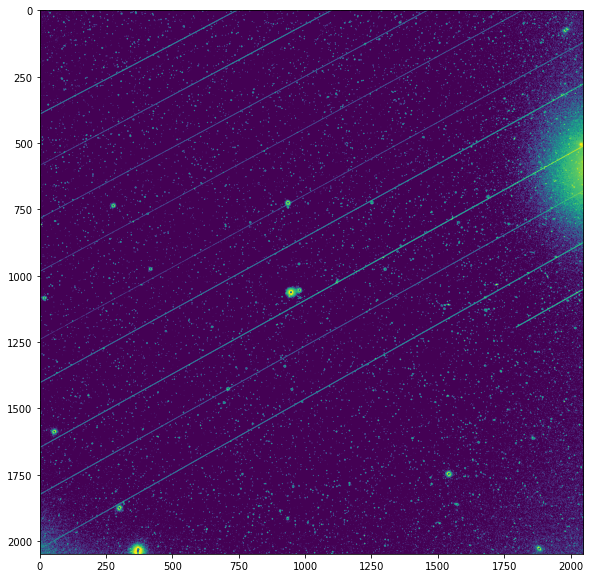

In [5]:
# to make sure we keep bright trails far away from the background we opt to check this out manually
histeq = img.copy()

n = 5
mean = histeq.mean()
std = histeq.std()
histeq[histeq > mean+n*std] = 0
histeq[histeq < mean-n*std] = 0

n = 3
mean = histeq.mean()
std = histeq.std()
histeq[histeq > mean+n*std] = mean+n*std
histeq[histeq < mean-n*std] = mean-n*std

hist, bars = np.histogram(img, "auto", density=True)
cdf = np.cumsum(hist*np.diff(bars))
                
keep_percent = 0.05
cutoff = np.where(cdf > 1-keep_percent)[0][0]

histeq[histeq < bars[cutoff]] = 0
# we could just do this histeq[histeq > 0] = 255
#  but too keep some gray and keep it nicer on the eyes 
# we renormalize differently
histeq = (histeq-histeq.mean())/histeq.std()
histeq -= histeq.min()

show(histeq)

<AxesSubplot:>

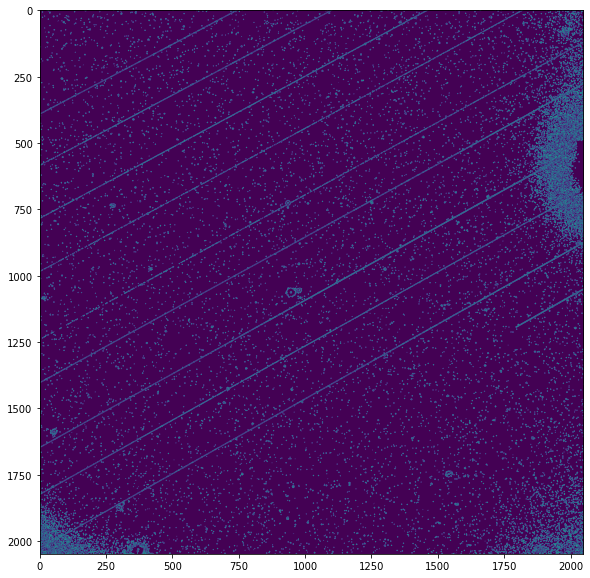

In [6]:
histeq = cv2.normalize(histeq, 0, 255)
histeq = cv2.convertScaleAbs(histeq)
threshold, thresholded_image = cv2.threshold(histeq, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
edges = cv2.Canny(thresholded_image, 100, 200)
show(edges)